In [1]:
from facenet_pytorch import MTCNN, InceptionResnetV1, fixed_image_standardization, training
import torch
from torch.utils.data import DataLoader, SubsetRandomSampler
from torch import optim
from torch.optim.lr_scheduler import MultiStepLR
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms
import numpy as np
import os

In [2]:
data_dir = 'facenet_pytorch/data/CustomTrain'

batch_size = 32
epochs = 8
workers = 0 if os.name == 'nt' else 8

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on device: {}'.format(device))

Running on device: cuda:0


In [4]:
mtcnn = MTCNN(
    image_size=160, margin=0, min_face_size=20,
    thresholds=[0.6, 0.7, 0.7], factor=0.709, post_process=True,
    device=device
)

In [5]:
dataset = datasets.ImageFolder(data_dir, transform=transforms.Resize((512, 512)))
dataset.samples = [
    (p, p.replace(data_dir, data_dir + '_cropped'))
        for p, _ in dataset.samples
]

In [30]:
dataset = datasets.ImageFolder(data_dir, transform=transforms.Resize((512, 512)))
dataset.samples = [
    (p, p.replace(data_dir, data_dir + '_cropped'))
        for p, _ in dataset.samples
]
        
loader = DataLoader(
    dataset,
    num_workers=workers,
    batch_size=batch_size,
    collate_fn=training.collate_pil
)

for i, (x, y) in enumerate(loader):
    mtcnn(x, save_path=y)
    print('\rBatch {} of {}'.format(i + 1, len(loader)), end='')
    
# Remove mtcnn to reduce GPU memory usage
del mtcnn

M:\AdversarialAttacks\InceptionResnet\facenet_pytorch\models\utils\detect_face.py:183: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  batch_boxes, batch_points = np.array(batch_boxes), np.array(batch_points)
M:\AdversarialAttacks\InceptionResnet\facenet_pytorch\models\mtcnn.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  boxes = np.array(boxes)
M:\AdversarialAttacks\InceptionResnet\facenet_pytorch\models\mtcnn.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarr

Batch 10 of 16

M:\AdversarialAttacks\InceptionResnet\facenet_pytorch\models\mtcnn.py:444: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  selected_boxes = np.array(selected_boxes)
M:\AdversarialAttacks\InceptionResnet\facenet_pytorch\models\mtcnn.py:446: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  selected_points = np.array(selected_points)


Batch 16 of 16

In [6]:
resnet = InceptionResnetV1(
    classify=True,
    pretrained='vggface2',
    num_classes=len(dataset.class_to_idx)
).to(device)

In [7]:
resnet.load_state_dict(torch.load('CustomTrained_StateDict.pth'))

<All keys matched successfully>

# Inference

In [8]:
def collate_fn(x):
    return x[0]

dataset = datasets.ImageFolder('facenet_pytorch/data/val')
dataset.idx_to_class = {i:c for c, i in dataset.class_to_idx.items()}
loader = DataLoader(dataset, collate_fn=collate_fn, num_workers=workers)

In [9]:
dataset.idx_to_class

{0: 'Ishan',
 1: 'Janvi',
 2: 'Rahul',
 3: 'Rushiraj',
 4: 'Shakti',
 5: 'Tirthraj',
 6: 'Vaishvi',
 7: 'Vidhi'}

In [10]:
mtcnn = MTCNN(
    image_size=160, margin=0, min_face_size=20,
    thresholds=[0.6, 0.7, 0.7], factor=0.709, post_process=True,
    device=device
)

In [12]:
aligned = []
names = []
for x, y in loader:
    x_aligned, prob = mtcnn(x, return_prob=True)
    if x_aligned is not None:
        print('Face detected with probability: {:8f}'.format(prob))
        aligned.append(x_aligned)
        names.append(dataset.idx_to_class[y])

Face detected with probability: 0.999442
Face detected with probability: 0.998941
Face detected with probability: 0.999992
Face detected with probability: 1.000000
Face detected with probability: 0.999982
Face detected with probability: 0.999572
Face detected with probability: 0.999247
Face detected with probability: 0.999961
Face detected with probability: 1.000000
Face detected with probability: 0.999888
Face detected with probability: 0.999994
Face detected with probability: 0.999991
Face detected with probability: 0.999574
Face detected with probability: 0.999972
Face detected with probability: 0.999998


In [13]:
#faces = faces.to(device)
faces = torch.stack(aligned).to(device)

outputs = resnet(faces)
prob, preds = torch.max(outputs, 1)
preds = preds.detach().cpu().numpy()
print([dataset.idx_to_class[p] for p in preds])

['Ishan', 'Ishan', 'Janvi', 'Janvi', 'Rahul', 'Rahul', 'Rushiraj', 'Rushiraj', 'Shakti', 'Shakti', 'Tirthraj', 'Tirthraj', 'Vaishvi', 'Vidhi', 'Vidhi']


# Single Image

In [ ]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2

transform = A.Compose([
    ToTensorV2()
])

# Read an image with OpenCV and convert it to the RGB colorspace
image = cv2.imread("facenet_pytorch/data/val/Rushiraj/rFile586.png")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Augment an image
transformed = transform(image=image)
transformed_image = transformed["image"]

In [ ]:
aligned = []
x_aligned, prob = mtcnn(image, return_prob=True)
aligned.append(x_aligned)

In [ ]:
#faces = faces.to(device)
faces = torch.stack(aligned).to(device)

outputs = resnet(faces)
prob, preds = torch.max(outputs, 1)
preds = preds.detach().cpu().numpy() 
print(prob, preds)
print([dataset.idx_to_class[p] for p in preds])

# Imprint Noise Matrix on Glasses

In [14]:
noise_matrix = torch.load('NoiseMatrix.pth')
noise_matrix=noise_matrix.squeeze(0)
noise_matrix.shape

torch.Size([3, 160, 160])

In [ ]:
x = noise_matrix.resize_([3, 40, 40])
x.shape

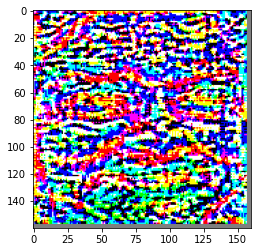

In [7]:
from imports import *
plt.imshow(np.transpose(utils.make_grid(noise_matrix.detach().cpu(), padding=2, normalize=True),(1,2,0)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<class 'numpy.ndarray'>


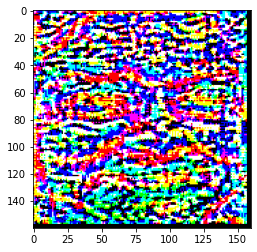

In [13]:
np_img = noise_matrix.detach().cpu().numpy()
print(type(np_img))
np_img.shape

np_img = np.transpose(np_img, (1,2,0))
plt.imshow(np_img)

# BD on Face

In [2]:
import cv2
import numpy as np
import dlib
from math import hypot

# Load the camera and Band Aid Image and create a mask
bd_image = cv2.imread("M:/AdversarialAttacks/effect_1/BD.jpeg")
frame = cv2.imread("M:/AdversarialAttacks/effect_1/rushi.jpg")
rows, cols, _ = frame.shape
nose_mask = np.zeros((rows, cols), np.uint8)

# Loading the Face Detector
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("M:/AdversarialAttacks/effect_1/shape_predictor_68_face_landmarks.dat")



nose_mask.fill(0)
gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

faces = detector(frame)
for face in faces:
    landmarks = predictor(gray_frame, face)

    # Nose coordinates
    top_nose = (landmarks.part(27).x, landmarks.part(27).y)
    center_nose = (landmarks.part(29).x, landmarks.part(29).y)

    left_eye_point = (landmarks.part(39).x, landmarks.part(39).y)
    right_eye_point = (landmarks.part(42).x, landmarks.part(42).y)

    nose_width = int(hypot(left_eye_point[0] - right_eye_point[0],
                            left_eye_point[1] - right_eye_point[1]))

    nose_height = int(nose_width * 1.73)   # 0.37 comes from H/W of the Image (373/100) - 1.73 is a random no

    # New nose position
    top_left = (int(center_nose[0] - nose_width / 2),
                    int(center_nose[1] - nose_height /2))

    bottom_right = (int(center_nose[0] + nose_width / 2),
                        int(center_nose[1] + nose_height / 2))

    # Adding the Band Aid Image
    bd_pic = cv2.resize(bd_image, (nose_width, nose_height))
    bd_pic_gray = cv2.cvtColor(bd_pic, cv2.COLOR_BGR2GRAY)
    _, nose_mask = cv2.threshold(bd_pic_gray, 25, 255, cv2.THRESH_BINARY_INV)

    nose_area = frame[top_left[1]: top_left[1] + nose_height,
                top_left[0]: top_left[0] + nose_width]

    nose_area_no_nose = cv2.bitwise_and(nose_area, nose_area, mask=nose_mask)

    final_nose = cv2.add(nose_area_no_nose, bd_pic)
    print("Final Nose Shape", final_nose.shape)

    frame[top_left[1]: top_left[1] + nose_height,
                top_left[0]: top_left[0] + nose_width] = final_nose
    

    #cv2.imshow("Final Nose", final_nose)

print(frame.shape)
#cv2.imshow("Frame", frame)
cv2.imwrite("JustTest.png", frame)
#key = cv2.waitKey(0)



Final Noise Shape (31, 18, 3)
(112, 112, 3)


True

In [61]:
import os
import cv2
import numpy as np
from pathlib import Path
from imutils import paths
from shutil import copyfile, copy
import dlib
from math import hypot

val_set = 'facenet_pytorch/data/NoiseValidation/Val/'
bd_image = cv2.imread("NoisyPatch.png")

# Loading the Face Detector
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("M:/AdversarialAttacks/effect_1/shape_predictor_68_face_landmarks.dat")


for img in paths.list_images(val_set):
    
    person_name = os.path.split(os.path.split(img)[0])[1]
    file_name = os.path.split(img)[1]
    
    #print(file_name)

    frame = cv2.imread(img)
    rows, cols, _ = frame.shape
    nose_mask = np.zeros((rows, cols), np.uint8)

    nose_mask.fill(0)
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    faces = detector(frame)
    for face in faces:
        landmarks = predictor(gray_frame, face)

        # Nose coordinates
        top_nose = (landmarks.part(27).x, landmarks.part(27).y)
        center_nose = (landmarks.part(29).x, landmarks.part(29).y)

        left_eye_point = (landmarks.part(39).x, landmarks.part(39).y)
        right_eye_point = (landmarks.part(42).x, landmarks.part(42).y)

        nose_width = int(hypot(left_eye_point[0] - right_eye_point[0],
                                left_eye_point[1] - right_eye_point[1]))

        nose_height = int(nose_width * 1.73)   # 0.37 comes from H/W of the Image (373/100) - 1.73 is a random no

        # New nose position
        top_left = (int(center_nose[0] - nose_width / 2),
                        int(center_nose[1] - nose_height /2))

        bottom_right = (int(center_nose[0] + nose_width / 2),
                            int(center_nose[1] + nose_height / 2))

        # Adding the Band Aid Image
        bd_pic = cv2.resize(bd_image, (nose_width, nose_height))
        bd_pic_gray = cv2.cvtColor(bd_pic, cv2.COLOR_BGR2GRAY)
        _, nose_mask = cv2.threshold(bd_pic_gray, 25, 255, cv2.THRESH_BINARY_INV)

        nose_area = frame[top_left[1]: top_left[1] + nose_height,
                    top_left[0]: top_left[0] + nose_width]

        nose_area_no_nose = cv2.bitwise_and(nose_area, nose_area, mask=nose_mask)

        final_nose = cv2.add(nose_area_no_nose, bd_pic)
        #print("Final Nose Shape", final_nose.shape)

        frame[top_left[1]: top_left[1] + nose_height,
                    top_left[0]: top_left[0] + nose_width] = final_nose

        #cv2.imshow("Final Nose", final_nose)

    print(frame.shape)
    #cv2.imshow("Frame", frame)
    
    path = 'facenet_pytorch/data/NoiseValidation/eps_1/{0}/{1}'.format(person_name, file_name)
    #print(path)
    cv2.imwrite('facenet_pytorch/data/NoiseValidation/eps_1/{0}/{1}'.format(person_name, file_name), frame)
    #key = cv2.waitKey(0)

        #copy(img, os.path.join('facenet_pytorch/data/NoiseValidation/eps_1/',person_name ))

(160, 160, 3)
(160, 160, 3)
(160, 160, 3)
(160, 160, 3)
(160, 160, 3)
(160, 160, 3)
(160, 160, 3)
(160, 160, 3)
(160, 160, 3)
(160, 160, 3)
(160, 160, 3)
(160, 160, 3)
(160, 160, 3)
(160, 160, 3)
(160, 160, 3)
(160, 160, 3)
(160, 160, 3)
(160, 160, 3)
(160, 160, 3)
(160, 160, 3)
(160, 160, 3)
(160, 160, 3)
(160, 160, 3)
(160, 160, 3)
(160, 160, 3)
(160, 160, 3)
(160, 160, 3)
(160, 160, 3)
(160, 160, 3)
(160, 160, 3)
(160, 160, 3)
(160, 160, 3)
(160, 160, 3)


# Normal Dataloader

In [67]:
def collate_fn(x):
    return x[0]

dataset = datasets.ImageFolder('facenet_pytorch/data/NoiseValidation/Val/')
dataset.idx_to_class = {i:c for c, i in dataset.class_to_idx.items()}
loader = DataLoader(dataset, collate_fn=collate_fn, num_workers=workers)

In [68]:
dataset.idx_to_class

{0: 'Ishan',
 1: 'Janvi',
 2: 'Rahul',
 3: 'Rushiraj',
 4: 'Shakti',
 5: 'Tirthraj',
 6: 'Vaishvi',
 7: 'Vidhi'}

In [69]:
mtcnn = MTCNN(
    image_size=160, margin=0, min_face_size=20,
    thresholds=[0.6, 0.7, 0.7], factor=0.709, post_process=True,
    device=device
)

In [70]:
aligned = []
names = []
for x, y in loader:
    x_aligned, prob = mtcnn(x, return_prob=True)
    if x_aligned is not None:
        print('Face detected with probability: {:8f}'.format(prob))
        aligned.append(x_aligned)
        names.append(dataset.idx_to_class[y])

Face detected with probability: 0.999932
Face detected with probability: 0.999917
Face detected with probability: 0.999834
Face detected with probability: 0.999947
Face detected with probability: 0.999640
Face detected with probability: 0.999784
Face detected with probability: 0.999742
Face detected with probability: 0.999966
Face detected with probability: 0.999996
Face detected with probability: 0.999989
Face detected with probability: 0.999938
Face detected with probability: 0.999986
Face detected with probability: 0.999999
Face detected with probability: 0.999993
Face detected with probability: 0.999975
Face detected with probability: 0.998795
Face detected with probability: 0.999885
Face detected with probability: 0.999945
Face detected with probability: 0.999957
Face detected with probability: 0.999994
Face detected with probability: 0.999997
Face detected with probability: 0.999905
Face detected with probability: 0.999988
Face detected with probability: 0.999987
Face detected wi

In [71]:
#faces = faces.to(device)
faces = torch.stack(aligned).to(device)

outputs = resnet(faces)
prob, preds = torch.max(outputs, 1)
preds = preds.detach().cpu().numpy()

real_names = [dataset.idx_to_class[p] for p in preds]
print([dataset.idx_to_class[p] for p in preds])

['Ishan', 'Ishan', 'Ishan', 'Ishan', 'Ishan', 'Ishan', 'Ishan', 'Janvi', 'Janvi', 'Janvi', 'Janvi', 'Janvi', 'Rahul', 'Rahul', 'Rahul', 'Rushiraj', 'Rushiraj', 'Rushiraj', 'Shakti', 'Shakti', 'Shakti', 'Tirthraj', 'Tirthraj', 'Tirthraj', 'Tirthraj', 'Tirthraj', 'Tirthraj', 'Vaishvi', 'Vaishvi', 'Vaishvi', 'Vidhi', 'Vidhi', 'Vidhi']


In [72]:
real_names

['Ishan',
 'Ishan',
 'Ishan',
 'Ishan',
 'Ishan',
 'Ishan',
 'Ishan',
 'Janvi',
 'Janvi',
 'Janvi',
 'Janvi',
 'Janvi',
 'Rahul',
 'Rahul',
 'Rahul',
 'Rushiraj',
 'Rushiraj',
 'Rushiraj',
 'Shakti',
 'Shakti',
 'Shakti',
 'Tirthraj',
 'Tirthraj',
 'Tirthraj',
 'Tirthraj',
 'Tirthraj',
 'Tirthraj',
 'Vaishvi',
 'Vaishvi',
 'Vaishvi',
 'Vidhi',
 'Vidhi',
 'Vidhi']

# Noisy Dataloader

In [73]:
def collate_fn(x):
    return x[0]

dataset = datasets.ImageFolder('facenet_pytorch/data/NoiseValidation/eps_1/')
dataset.idx_to_class = {i:c for c, i in dataset.class_to_idx.items()}
loader = DataLoader(dataset, collate_fn=collate_fn, num_workers=workers)

In [74]:
dataset.idx_to_class

{0: 'Ishan',
 1: 'Janvi',
 2: 'Rahul',
 3: 'Rushiraj',
 4: 'Shakti',
 5: 'Tirthraj',
 6: 'Vaishvi',
 7: 'Vidhi'}

In [75]:
mtcnn = MTCNN(
    image_size=160, margin=0, min_face_size=20,
    thresholds=[0.6, 0.7, 0.7], factor=0.709, post_process=True,
    device=device
)

In [76]:
aligned = []
names = []
for x, y in loader:
    x_aligned, prob = mtcnn(x, return_prob=True)
    if x_aligned is not None:
        print('Face detected with probability: {:8f}'.format(prob))
        aligned.append(x_aligned)
        names.append(dataset.idx_to_class[y])

Face detected with probability: 0.999932
Face detected with probability: 0.999917
Face detected with probability: 0.999866
Face detected with probability: 0.999935
Face detected with probability: 0.999640
Face detected with probability: 0.999784
Face detected with probability: 0.999742
Face detected with probability: 0.999966
Face detected with probability: 0.999854
Face detected with probability: 0.996171
Face detected with probability: 0.999938
Face detected with probability: 0.998354
Face detected with probability: 0.998742
Face detected with probability: 0.997863
Face detected with probability: 0.999708
Face detected with probability: 0.998096
Face detected with probability: 0.999304
Face detected with probability: 0.999259
Face detected with probability: 0.997989
Face detected with probability: 0.999865
Face detected with probability: 0.999929
Face detected with probability: 0.998905
Face detected with probability: 0.999463
Face detected with probability: 0.999917
Face detected wi

In [77]:
#faces = faces.to(device)
faces = torch.stack(aligned).to(device)

outputs = resnet(faces)
prob, preds = torch.max(outputs, 1)
preds = preds.detach().cpu().numpy()

noisy_image_results = [dataset.idx_to_class[p] for p in preds]
print([dataset.idx_to_class[p] for p in preds])

['Rahul', 'Rahul', 'Vidhi', 'Janvi', 'Vidhi', 'Rahul', 'Vidhi', 'Janvi', 'Ishan', 'Janvi', 'Janvi', 'Ishan', 'Ishan', 'Rahul', 'Rahul', 'Rushiraj', 'Rushiraj', 'Rushiraj', 'Shakti', 'Shakti', 'Shakti', 'Tirthraj', 'Tirthraj', 'Tirthraj', 'Tirthraj', 'Vaishvi', 'Vaishvi', 'Vaishvi', 'Tirthraj', 'Vidhi', 'Vidhi']


In [78]:
noisy_image_results

['Rahul',
 'Rahul',
 'Vidhi',
 'Janvi',
 'Vidhi',
 'Rahul',
 'Vidhi',
 'Janvi',
 'Ishan',
 'Janvi',
 'Janvi',
 'Ishan',
 'Ishan',
 'Rahul',
 'Rahul',
 'Rushiraj',
 'Rushiraj',
 'Rushiraj',
 'Shakti',
 'Shakti',
 'Shakti',
 'Tirthraj',
 'Tirthraj',
 'Tirthraj',
 'Tirthraj',
 'Vaishvi',
 'Vaishvi',
 'Vaishvi',
 'Tirthraj',
 'Vidhi',
 'Vidhi']

In [82]:
real_names 

['Ishan',
 'Ishan',
 'Ishan',
 'Ishan',
 'Ishan',
 'Ishan',
 'Ishan',
 'Janvi',
 'Janvi',
 'Janvi',
 'Janvi',
 'Janvi',
 'Rahul',
 'Rahul',
 'Rahul',
 'Rushiraj',
 'Rushiraj',
 'Rushiraj',
 'Shakti',
 'Shakti',
 'Shakti',
 'Tirthraj',
 'Tirthraj',
 'Tirthraj',
 'Tirthraj',
 'Tirthraj',
 'Tirthraj',
 'Vaishvi',
 'Vaishvi',
 'Vaishvi',
 'Vidhi',
 'Vidhi',
 'Vidhi']

In [80]:
def intersection(lst1, lst2):
    return list(set(lst1) & set(lst2))
  

print(intersection(real_names, noisy_image_results))

['Janvi', 'Vaishvi', 'Shakti', 'Ishan', 'Rushiraj', 'Tirthraj', 'Vidhi', 'Rahul']


In [81]:
common = []
for i, j in zip(real_names, noisy_image_results):
    if i == j:
        common.append(i)
print(common)

['Janvi', 'Janvi', 'Janvi', 'Rahul', 'Rahul', 'Rushiraj', 'Rushiraj', 'Rushiraj', 'Shakti', 'Shakti', 'Shakti', 'Tirthraj', 'Tirthraj', 'Tirthraj', 'Tirthraj', 'Vaishvi', 'Vidhi']


In [8]:
bd_image = cv2.imread("M:/AdversarialAttacks/effect_1/BD.jpeg")
type(bd_image)
bd_image.shape

(373, 100, 3)

In [9]:
bd_image = cv2.resize(bd_image, (50, 50))

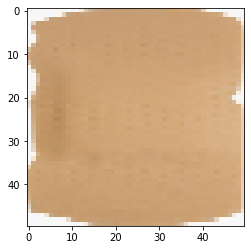

In [10]:
import matplotlib.pyplot as plt

bd_image = cv2.cvtColor(bd_image, cv2.COLOR_BGR2RGB)
plt.imshow(bd_image)

In [14]:
np_img = cv2.resize(np_img, (bd_image.shape[1], bd_image.shape[0]))
np_img.shape

(50, 50, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


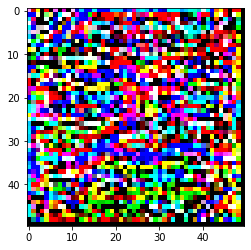

In [15]:
np_img = cv2.cvtColor(np_img, cv2.COLOR_BGR2RGB)

plt.imshow(np_img)

In [16]:
test = bd_image + bd_image*np_img

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


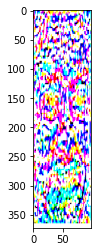

In [32]:
test = cv2.cvtColor(test, cv2.COLOR_BGR2RGB)

plt.imshow(test)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


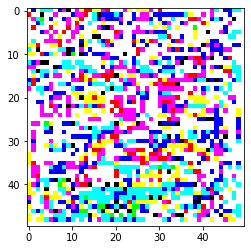

In [17]:
test = cv2.cvtColor(test, cv2.COLOR_BGR2RGB)

plt.imshow(test)

In [18]:
cv2.imwrite("NoisyPatch.png", test)

True

# Placing Noisy Patch on Face

In [38]:
import cv2
import numpy as np
import dlib
from math import hypot

# Load the camera and Band Aid Image and create a mask
bd_image = cv2.imread("NoisyPatch.png")

frame = cv2.imread("M:/AdversarialAttacks/effect_1/rushi.jpg")
rows, cols, _ = frame.shape
nose_mask = np.zeros((rows, cols), np.uint8)

# Loading the Face Detector
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("M:/AdversarialAttacks/effect_1/shape_predictor_68_face_landmarks.dat")



nose_mask.fill(0)
gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

faces = detector(frame)
for face in faces:
    landmarks = predictor(gray_frame, face)

    # Nose coordinates
    top_nose = (landmarks.part(27).x, landmarks.part(27).y)
    center_nose = (landmarks.part(29).x, landmarks.part(29).y)

    left_eye_point = (landmarks.part(39).x, landmarks.part(39).y)
    right_eye_point = (landmarks.part(42).x, landmarks.part(42).y)

    nose_width = int(hypot(left_eye_point[0] - right_eye_point[0],
                            left_eye_point[1] - right_eye_point[1]))

    nose_height = int(nose_width * 1.73)   # 0.37 comes from H/W of the Image (373/100) - 1.73 is a random no

    # New nose position
    top_left = (int(center_nose[0] - nose_width / 2),
                    int(center_nose[1] - nose_height /2))

    bottom_right = (int(center_nose[0] + nose_width / 2),
                        int(center_nose[1] + nose_height / 2))

    # Adding the Band Aid Image
    bd_pic = cv2.resize(bd_image, (nose_width, nose_height))
    bd_pic_gray = cv2.cvtColor(bd_pic, cv2.COLOR_BGR2GRAY)
    _, nose_mask = cv2.threshold(bd_pic_gray, 25, 255, cv2.THRESH_BINARY_INV)

    nose_area = frame[top_left[1]: top_left[1] + nose_height,
                top_left[0]: top_left[0] + nose_width]

    nose_area_no_nose = cv2.bitwise_and(nose_area, nose_area, mask=nose_mask)

    final_nose = cv2.add(nose_area_no_nose, bd_pic)
    print("Final Nose Shape", final_nose.shape)

    frame[top_left[1]: top_left[1] + nose_height,
                top_left[0]: top_left[0] + nose_width] = final_nose

    #cv2.imshow("Final Nose", final_nose)

print(frame.shape)
#cv2.imshow("Frame", frame)
cv2.imwrite("TEST-Resize-FinalNoisyImage.png", frame)
#key = cv2.waitKey(0)




Final Nose Shape (31, 18, 3)
(112, 112, 3)


# Noisy Patch Inference

In [20]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2

transform = A.Compose([
    ToTensorV2()
])

# Read an image with OpenCV and convert it to the RGB colorspace
image = cv2.imread("TEST-Resize-FinalNoisyImage.png")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Augment an image
transformed = transform(image=image)
transformed_image = transformed["image"]

In [25]:
aligned = []
x_aligned, prob = mtcnn(image, return_prob=True)
aligned.append(x_aligned)

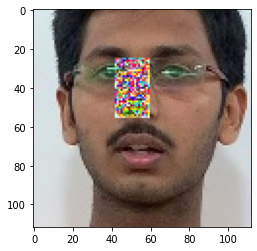

In [26]:
from imports import *
plt.imshow(np.transpose(utils.make_grid(transformed_image.detach().cpu(), padding=2, normalize=False),(1,2,0)))

In [51]:
resnet.eval()              # REQUIRED for Inference or else you will get the BatchNorm 1 channel error

#faces = faces.to(device)
faces = torch.stack(aligned).to(device)

outputs = resnet(faces)
prob, preds = torch.max(outputs, 1)
preds = preds.detach().cpu().numpy() 
print(prob, preds)
print([dataset.idx_to_class[p] for p in preds])

tensor([6.2989], device='cuda:0', grad_fn=<MaxBackward0>) [0]
['Ishan']


In [35]:
resnet.eval()              # REQUIRED for Inference or else you will get the BatchNorm 1 channel error

#faces = faces.to(device)
faces = torch.stack(aligned).to(device)

outputs = resnet(faces)
prob, preds = torch.max(outputs, 1)
preds = preds.detach().cpu().numpy() 
print(prob, preds)
print([dataset.idx_to_class[p] for p in preds])

tensor([7.1241], device='cuda:0', grad_fn=<MaxBackward0>) [0]
['Ishan']


# Normal Image Inference

In [56]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2

transform = A.Compose([
    ToTensorV2()
])

# Read an image with OpenCV and convert it to the RGB colorspace
image = cv2.imread("Nose.png")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Augment an image
transformed = transform(image=image)
transformed_image = transformed["image"]

In [57]:
aligned = []
x_aligned, prob = mtcnn(image, return_prob=True)
aligned.append(x_aligned)

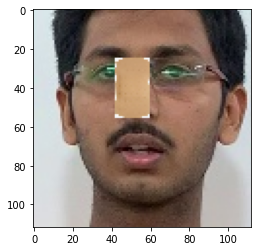

In [58]:
from imports import *
plt.imshow(np.transpose(utils.make_grid(transformed_image.detach().cpu(), padding=2, normalize=False),(1,2,0)))

In [59]:
resnet.eval()

#faces = faces.to(device)
faces = torch.stack(aligned).to(device)

outputs = resnet(faces)
prob, preds = torch.max(outputs, 1)
preds = preds.detach().cpu().numpy() 
print(prob, preds)
print([dataset.idx_to_class[p] for p in preds])

tensor([8.0881], device='cuda:0', grad_fn=<MaxBackward0>) [3]
['Rushiraj']
